<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/main_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook uses the Julich atlas (threshold at prob>0.75) to segment data from Garvert et al. 2017 eLife.
We define hippocampal ROIs including Dentate Gyrus and Cornu Ammonis (no subiculum for now), and segment them according to y=-21 (as in Poppenk et al. 2013 eLife).
The main thing to change is in the section "Load beta map" (i.e. folder and path specification).

# Parameters

In [ ]:
threshold = 20 # Threshold for the probabilistic atlas (there is a tradeoff between reliability and number of voxels
normalizeSR = True # Whether to use a row-normalized SR or not
ub = 100 # Bound for the model coefficients
metric = 'correlation' # Metric to use to measure neural dissimilarity

## Install and import packages

In [ ]:
!pip install nilearn

In [ ]:
from nilearn import image
from nilearn import plotting, image, datasets
from nilearn.datasets import load_mni152_template
from nilearn.datasets import fetch_atlas_aal
import nibabel as nib
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import tempfile
import os
from PIL import Image
from copy import copy
from nilearn.image import resample_to_img
import matplotlib.colors as mcolors
from scipy.optimize import minimize
from scipy.special import expit
from scipy.special import logit
from nilearn import plotting, image, datasets, masking
from scipy.stats import ttest_rel
from scipy.linalg import expm

## Functions

## Segmentation
Functions to segment the hippocampus along the x (left and right) and y (posterior and anterior) axes.

In [ ]:
def segmentHippocampusX(mask, x_index):
  # This function segments the mask along the x axis, into left and right.
  # Note: mask is a 3D boolean array.
  # In the MNI, the midline corresponds to x=0. However, we need to convert it
  # into voxel coordinates.
  # The output is a dictionary with two keys (left and right).

  right = mask.copy() # I use copy to avoid getting views of variables
  left = mask.copy()

  right[:x_index,:,:] = 0
  # then y_index is set to 0 (and discarded)
  end = mask.shape[0]
  left[x_index:end,:,:] = 0

  return {'left': left,
          'right': right}


In [ ]:
def segmentHippocampusY(mask, y_index):
  # This function takes one single hippocampal mask MASK and split into two along the
  # longitudinal axis (y dimensions), at y_index
  # Note: mask is a 3D boolean array.
  # In the MNI, we go from posterior (-) to anterior (+).
  # Thus, a mask for posterior should set all voxels > y_index to 0.

  anterior_mask = mask.copy() # I use copy to avoid getting views of variables
  posterior_mask = mask.copy()
  end = mask.shape[1]

  posterior_mask[:,y_index:end,:] = 0 # For the posterior, everything more anterior
  # then y_index is set to 0 (and discarded)
  anterior_mask[:,:y_index,:] = 0 # Conversely, for the anterior


  return {'posterior': posterior_mask,
          'anterior': anterior_mask}

## Loading data

In [ ]:
def load_beta_images(run_dir, condition_ids):
    betas = []
    for cond_id in condition_ids:
        pattern = f"_object_{cond_id}_mean_beta_np.nii.gz"
        files = [f for f in os.listdir(run_dir) if pattern in f]
        assert len(files) == 1, f"Expected one match for {pattern}"
        img = nib.load(os.path.join(run_dir, files[0]))
        betas.append(img.get_fdata().flatten())  # flatten to 1D voxel vector
    return np.vstack(betas)  # shape (7, n_voxels)

In [ ]:
def extractBetas(beta_img, mask_img):
  # This function take a .nii image from beta_img and from mask_imgs
  # it put them in the same reference frame and then use the latter as a boolean
  # mask
  # The function returns a vector with n elements, where n is the number of non-
  # zero elemnts in mask_img

  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)

  beta_data = beta_img.get_fdata()
  mask_data = resampled_mask_img.get_fdata()

  mask_bool = mask_data > 0  # Ensure mask is binary

  masked_betas = beta_data[mask_bool]
  return masked_betas

## Others

In [ ]:
def computeSR(T,gamma, normalize=False):
  # This function computes the SR matrix from a transition matrix T
  # and a gamma value.
  # If normalize=True, SR will be row-normalized, making it alike probabilities
  I = np.eye(T.shape[0])
  difference = I - gamma * T
  # Compute the inverse of (I - gamma * T)
  M = np.linalg.inv(difference)
  if normalize:
    M = M / M.sum(axis=1, keepdims=True)
  return M

In [ ]:
def computeDK(A, alpha):
  degrees = np.sum(A, axis=1)
  D = np.diag(degrees)
  L = D - A
  K = expm(-alpha * L)
  return K

In [ ]:
def corr_triangles(M1, M2):
  # To correlate neural dissimilarity and model dissimilarity, we need to
  # discard the diagonal. We can't just use squareform because SR is not
  # symmetric necessarily
  M1 = M1[~np.eye(M1.shape[0], dtype=bool)]
  M2 = M2[~np.eye(M2.shape[0], dtype=bool)]
  return pearsonr(M1, M2)

# Define ROIs
In this section the main things to decide are:


*   Probability threshold: Julich atlas is probablistic, so to get binary masks (where a voxel is assigned to 1 only if it belongs to the ROI) we need to threshold it. The value is chosen in line with previous studies (Barnavelli et al. 2025 Nat Commun) and it also corresponds to a sort of elbow in voxel reliability (there is a tradeoff between # of selected voxels and reliability)
*   ROI definition. For now, we define the hippocampus as DG + CA



## Load Juelich brain atlas

In [ ]:
julich = datasets.fetch_atlas_juelich("prob-1mm")
julich_img = image.load_img(julich.maps)
julich_data = julich_img.get_fdata()
julich_labels = julich.labels

[fetch_atlas_juelich] Dataset found in /root/nilearn_data/fsl

In [ ]:
CA_idx = julich_labels.index("GM Hippocampus cornu ammonis") - 1
DG_idx = julich_labels.index("GM Hippocampus dentate gyrus") - 1

In [ ]:
CA = (julich_data[..., CA_idx] > threshold)
DG = (julich_data[..., DG_idx] > threshold)

# This now returns a 3D boolean array
HP = CA | DG

/tmp/ipython-input-2003817921.py:7: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')
/tmp/ipython-input-2003817921.py:7: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')


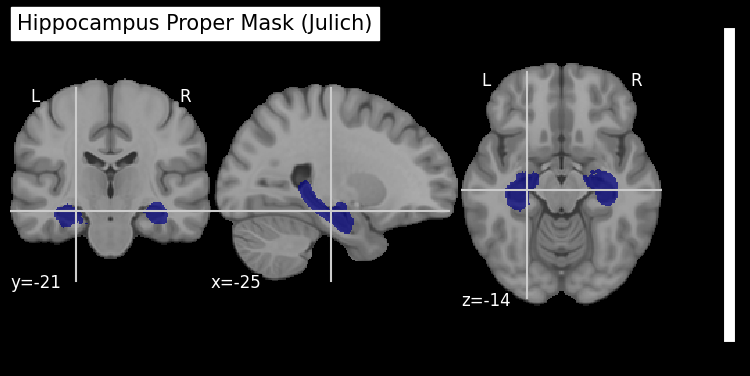

In [ ]:
mni_img = datasets.load_mni152_template(resolution=1)

# Step 2: Convert your HP mask to a NIfTI image
hp_mask_img = nib.Nifti1Image(HP.astype(np.uint8), affine=julich_img.affine)

# Step 3: Resample the mask to match the MNI template (if needed)
hp_mask_resampled = resample_to_img(hp_mask_img, mni_img, interpolation='nearest')

# Step 4: Plot the mask over the MNI template
plotting.plot_roi(hp_mask_resampled, bg_img=mni_img, title="Hippocampus Proper Mask (Julich)", cut_coords=[-25,-21, -14])
plotting.show()

## Segment into left and right

In [ ]:
mni_x = 0
affine = julich_img.affine
inv_affine = np.linalg.inv(affine) # transform MNI coordinate into matrix indexes
x_index, _, _ = np.round(inv_affine @ np.array([mni_x, 0, 0, 1])).astype(int)[:3]

# Fill masks
# Anterior = voxels in hippocampus labels at y >= y_index
sagittal_segmentation = segmentHippocampusX(HP, x_index)

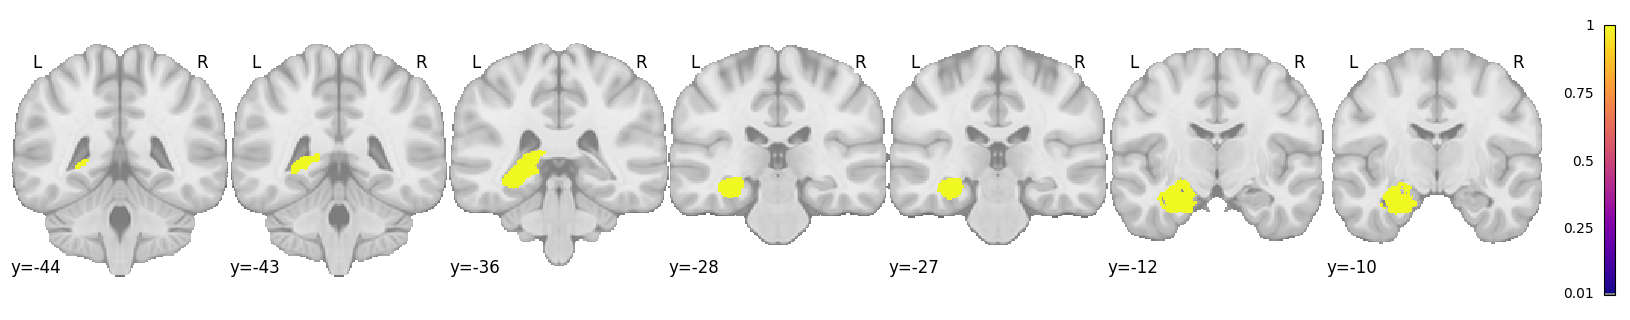

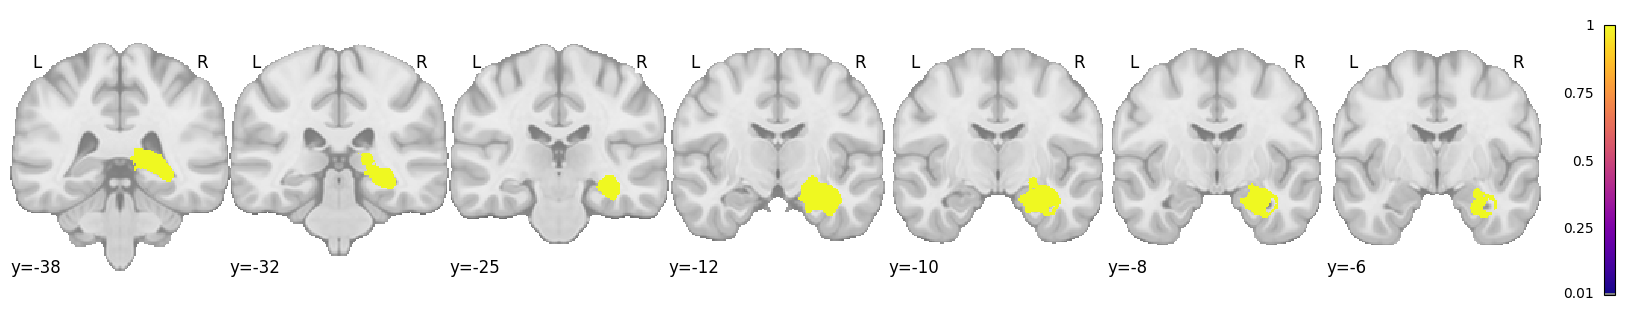

In [ ]:
for h in sagittal_segmentation:
  plotting.plot_stat_map(
      nib.Nifti1Image(sagittal_segmentation[h].astype(np.uint8), affine),
      bg_img=mni_img,
      display_mode="y",
      draw_cross=False,
      threshold=0.01,
      black_bg=False,
      colorbar=True,
      cmap="plasma",
      vmin=0,
      vmax=1
  )
plotting.show()

## Segment into anterior and posterior

In [ ]:
# Convert y = -21 MNI coordinate to voxel index
mni_y = -21 # Poppenk et al. 2013
affine = julich_img.affine
inv_affine = np.linalg.inv(affine) # transform MNI coordinate into matrix indexes
_, y_index, _ = np.round(inv_affine @ np.array([0, mni_y, 0, 1])).astype(int)[:3]

# Fill masks
# Anterior = voxels in hippocampus labels at y >= y_index
masks = {
    h: segmentHippocampusY(seg, y_index)
    for h, seg in sagittal_segmentation.items()
}

# h -> roi -> NIfTI image
masks_img = {
    h: {
        roi: nib.Nifti1Image(arr.astype(np.uint8), affine)
        for roi, arr in rois.items()
    }
    for h, rois in masks.items()
}

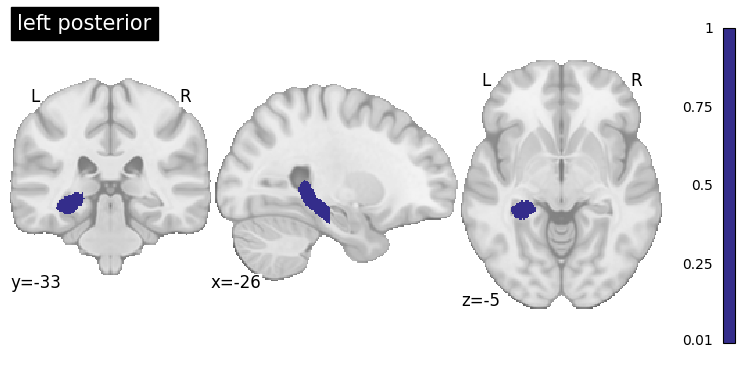

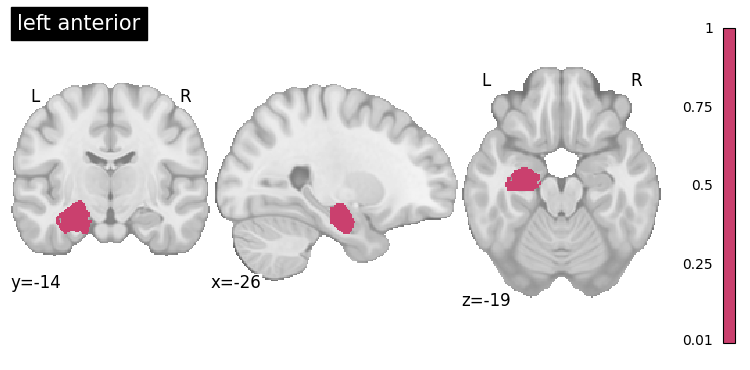

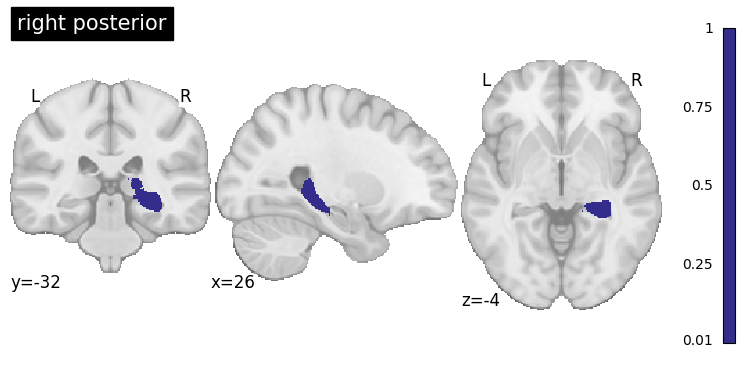

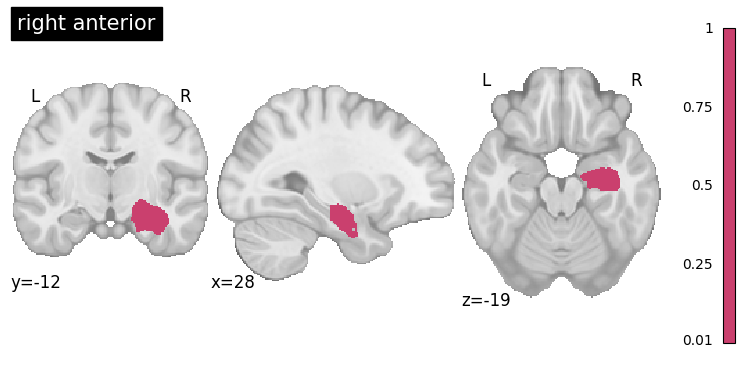

In [ ]:
# Check: visualize the longitudinal axis segmentation
colors = {"posterior": '#342d8bff',
          "anterior": '#ca406eff'}
for h in masks_img:
  for roi in masks_img[h]:
    plotting.plot_stat_map(
        masks_img[h][roi],
        bg_img=mni_img,
        draw_cross=False,
        threshold=0.01,
        black_bg=False,
        colorbar=True,
        cmap=mcolors.ListedColormap([[0, 0, 0, 0], colors[roi]]),
        vmin=0,
        vmax=1,
        title=h + " " + roi
    )
  plotting.show()

# Load beta maps

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# A-L's new version

import os
import numpy as np
import nibabel as nib

# Parameters
items = [2, 4, 6, 7, 8, 9, 10]
nItems = len(items)
nParticipants = 23
participants = np.arange(1, nParticipants + 1)

main_folder = "/content/drive/MyDrive/betas_nopatch/"
print(f"Loading mean beta maps from: {main_folder}")

# Load all mean beta maps
all_imgs = []  # nested list: [participant][item] = Nifti image

for subj_id in participants:
    subj_str = f"subject_{subj_id:02d}"
    subj_dir = os.path.join(main_folder, subj_str, "mean_betas_np")

    if not os.path.exists(subj_dir):
        print(f"Missing folder for {subj_str}, skipping.")
        continue

    subj_imgs = []
    for item in items:
        beta_filename = f"sub-{subj_id:02d}_object_{item}_mean_beta_np.nii.gz"
        beta_path = os.path.join(subj_dir, beta_filename)

        if os.path.exists(beta_path):
            subj_imgs.append(nib.load(beta_path))
        else:
            print(f"Missing beta: {beta_filename}")
            subj_imgs = []  # Clear list if incomplete
            break  # skip participant if missing data

    if subj_imgs and len(subj_imgs) == nItems:
        all_imgs.append(subj_imgs)
        print(f"Loaded {len(subj_imgs)} betas for {subj_str}")
    else:
        print(f"Skipping {subj_str} (incomplete data)")

print(f"\nSuccessfully loaded mean betas for {len(all_imgs)} participants.")

Loading mean beta maps from: /content/drive/MyDrive/betas_nopatch/
Loaded 7 betas for subject_01
Loaded 7 betas for subject_02
Loaded 7 betas for subject_03
Loaded 7 betas for subject_04
Loaded 7 betas for subject_05
Loaded 7 betas for subject_06
Loaded 7 betas for subject_07
Loaded 7 betas for subject_08
Loaded 7 betas for subject_09
Loaded 7 betas for subject_10
Loaded 7 betas for subject_11
Loaded 7 betas for subject_12
Loaded 7 betas for subject_13
Loaded 7 betas for subject_14
Loaded 7 betas for subject_15
Loaded 7 betas for subject_16
Loaded 7 betas for subject_17
Loaded 7 betas for subject_18
Loaded 7 betas for subject_19
Loaded 7 betas for subject_20
Loaded 7 betas for subject_21
Loaded 7 betas for subject_22
Loaded 7 betas for subject_23

Successfully loaded mean betas for 23 participants.


# Extract betas for ROIs

In [ ]:
# Slice the beta maps
# extractBetas extract the betas for the defined ROI
# Note: voxels is a list of nParticipants elements.
# Each element is a dictionary mirroring the structure of "mask_img", i.e.
# two keys (left and right), whose values have respectively two keys themselves
# (posterior and anterior).
# The voxels[p][hemisphere][posterior] is then the matrix of ROI responses to
# each of the seven items.

voxels = [
    {
        h: {
            roi: [extractBetas(item, masks_img[h][roi]) for item in subj]
            for roi in masks_img[h]
        }
        for h in masks_img
    }
    for subj in all_imgs
]

/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_mask_img = image.resample_to_img(mask_img, target_img=beta_img, interpolation='nearest', force_resample=True)
/tmp/ipython-input-1931706366.py:8: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. 

In [ ]:
neural_DSMs = [
    {
        h: {
            roi: squareform(pdist(np.asarray(subj[h][roi]), metric=metric))
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in voxels
]

# Model-based analyses

## Define the adjacency matric and the SR

In [ ]:
# Step 1: Define the adjacency matrix (12x12 binary matrix where 1 encodes a connection and 0 no connection)
# This is from Valerio's Matlab matrix!
A = np.array([
    [0,1,1,1,0,0,0,0,0,0,0,0],
    [1,0,0,1,1,0,0,0,0,0,0,0],
    [1,0,0,1,0,1,1,0,0,0,0,0],
    [1,1,1,0,1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0,0,1,0,0],
    [0,0,1,1,0,1,0,1,0,1,1,0],
    [0,0,0,0,1,0,1,0,1,0,1,1],
    [0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,0,0,0,1,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,1,0,1,0,1],
    [0,0,0,0,0,0,0,1,1,0,1,0]
])
T = A / A.sum(axis=1, keepdims=True)

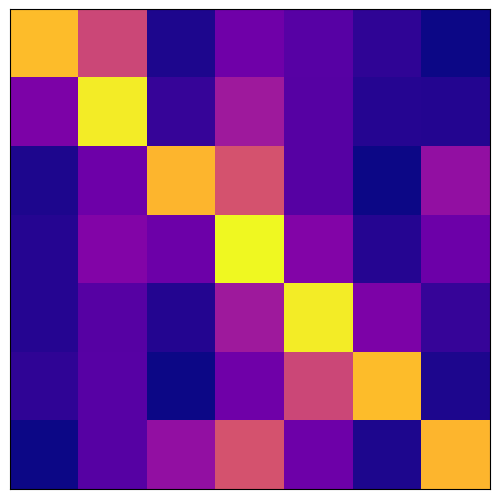

In [ ]:
items_idx = [i-1 for i in items]
SR = computeSR(T,0.85)
SR7 =  SR[np.ix_(items_idx, items_idx)]
fig,ax = plt.subplots()
img = ax.imshow(SR7, cmap='plasma', aspect='equal')

# Add a colorbar to show the scale
#fig.colorbar(img, label='SR')
ax.set_yticks([])
ax.set_xticks([])


# Remove padding around the figure
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.tight_layout(pad=0)


## Fit gamma to RSAs
The model now uses MSE as loss function. The form of the model is Y* = beta0 + beta1*SR(i,j), where SR is parametrized by $\gamma$.

In [ ]:
def full_objective(theta,
                   neural_DSM,
                   A,
                   model="SR",
                   normalize=normalizeSR):

    beta1 = theta[1]
    beta2 = -np.exp(theta[2]) # This enforces beta2 to be negative

    if model=="SR":
      gamma = expit(theta[0])
      T = A / A.sum(axis=1, keepdims=True)
      SR = computeSR(T, gamma)
      # Note: the SR is a measure of similarity, while neural_DSM is a measure of
      # dissimilarity: thus, beta2 should be negative

      # Subset the matrix
      x = SR[np.ix_(items_idx, items_idx)]

    elif model=="DK":
      alpha = theta[0]
      K = computeDK(A, alpha)
      x = K[np.ix_(items_idx, items_idx)]


    mask = ~np.eye(len(items_idx), dtype=bool)
    X = beta1 + beta2*x[mask].flatten()
    Y = neural_DSM[mask].flatten()

    D = (Y-X)**2
    mse = np.mean(D)
    #mse = 1 - pearsonr(x,y)[0]
    return mse

### DK

In [ ]:
# Model fitting
# This cell fit the SR model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(0, 100), (-100, 100), (-100, 100)]

res = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "DK", normalizeSR),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_DSMs
]

In [ ]:
# I get gamma from the list of dictionaries
alphas = [
    {
        h: {
            roi: res[h][roi].x[0]
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

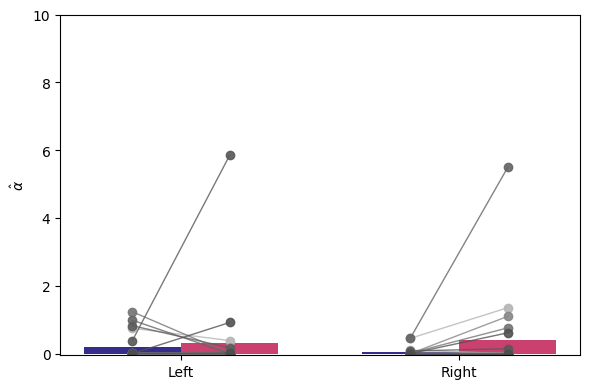

In [ ]:
# Transform into array to compute the mean
# Data is (2x2xnParticipants). The first dimension is the hemisphere, the second
# is the ROI (posterior and anterior).
data = np.array([
     [[alphas[p]['left']['posterior'] for p in range(nParticipants)],  # Left, Posterior
     [alphas[p]['left']['anterior'] for p in range(nParticipants)]], # Left, Anterior
    [[alphas[p]['right']['posterior'] for p in range(nParticipants)],  # Right, Posterior
     [alphas[p]['right']['anterior'] for p in range(nParticipants)]]  # Right, Anterior
])

# Compute means: (2, 2) → (hemisphere, location)
means = np.mean(data, axis=2)

# Setup
labels = ['Left', 'Right']
x = np.arange(len(labels))  # [0, 1]
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))

# Plot: Posterior bars on left, Anterior bars on right within each hemisphere group
colors = ['#342d8bff', '#ca406eff']  # Posterior = blue, Anterior = orange

bars_post = ax.bar(x - width/2, means[:, 0], width, label='pHPC', color=colors[0])
bars_ant  = ax.bar(x + width/2, means[:, 1], width, label='aHPC',  color=colors[1])

# Plot participant-level lines and dots
jitter = 0

greys = [str(0.3 + 0.5 * i / (nParticipants - 1)) for i in range(nParticipants)]
greys = list(reversed(greys))
participant_labels = participants

for p in range(nParticipants):
    color = greys[p]
    for i,h in enumerate(alphas[p].keys()):
        x_post = x[i] - width/2
        x_ant  = x[i] + width/2
        y_post = alphas[p][h]['posterior']
        y_ant  = alphas[p][h]['anterior']

        # Line connecting posterior and anterior
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color=color, alpha=0.8, linewidth=1)

        # Dots
        ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        ax.plot(x_ant,  y_ant,  'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\alpha}$')
ax.set_ylim(-0.05, 10)

# Get existing bar legend handles
existing_handles, existing_labels = ax.get_legend_handles_labels()

plt.tight_layout()

plt.show()

In [ ]:
from scipy.stats import ttest_rel

df = nParticipants - 1

# Left hemisphere
t_stat_left, p_left = ttest_rel(
    [alphas[p]['left']['posterior'] for p in range(nParticipants)],
    [alphas[p]['left']['anterior'] for p in range(nParticipants)]
)
print(f"DK Left hemisphere:  t({df}) = {t_stat_left:.3f},  p = {p_left:.3f}")

# Right hemisphere
t_stat_right, p_right = ttest_rel(
    [alphas[p]['right']['posterior'] for p in range(nParticipants)],
    [alphas[p]['right']['anterior'] for p in range(nParticipants)]
)
print(f"DK Right hemisphere: t({df}) = {t_stat_right:.3f},  p = {p_right:.3f}")

DK Left hemisphere:  t(22) = -0.536,  p = 0.597
DK Right hemisphere: t(22) = -1.628,  p = 0.118


### SR

In [ ]:
# Model fitting
# This cell fit the SR model to participants ROIs.
# We save the result into "res", which contains res.fun (loss) and res.x
# (estimated parameters)

x0 = [0.0, 0.0, 0.0]
bounds = [(-5, 5), (-100, 100), (-100, ub)]

res = [
    {
        h: {
            roi: minimize(
                full_objective,
                x0=x0,
                args=(subj[h][roi], A, "SR", normalizeSR),
                bounds=bounds,
            )
            for roi in subj[h]
        }
        for h in subj
    }
    for subj in neural_DSMs
]

In [ ]:
# I get gamma from the list of dictionaries
gammas = [
    {
        h: {
            roi: expit(res[h][roi].x[0])
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

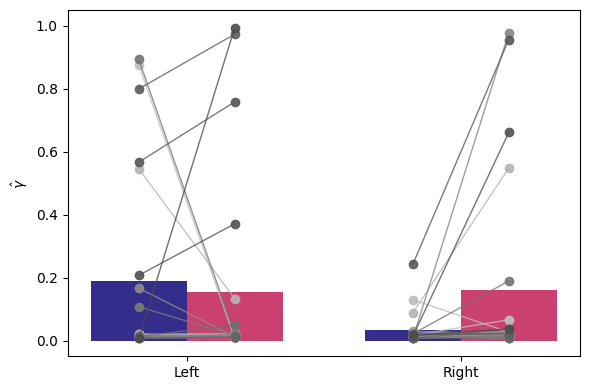

In [ ]:
# Transform into array to compute the mean
# Data is (2x2xnParticipants). The first dimension is the hemisphere, the second
# is the ROI (posterior and anterior).
data = np.array([
     [[gammas[p]['left']['posterior'] for p in range(nParticipants)],  # Left, Posterior
      [gammas[p]['left']['anterior'] for p in range(nParticipants)]], # Left, Anterior
     [[gammas[p]['right']['posterior'] for p in range(nParticipants)],  # Right, Posterior
      [gammas[p]['right']['anterior'] for p in range(nParticipants)]]  # Right, Anterior
])

# Compute means: (2, 2) → (hemisphere, location)
means = np.mean(data, axis=2)

# Setup
labels = ['Left', 'Right']
x = np.arange(len(labels))  # [0, 1]
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))

# Plot: Posterior bars on left, Anterior bars on right within each hemisphere group
colors = ['#342d8bff', '#ca406eff']  # Posterior = blue, Anterior = orange

bars_post = ax.bar(x - width/2, means[:, 0], width, label='pHPC', color=colors[0])
bars_ant  = ax.bar(x + width/2, means[:, 1], width, label='aHPC', color=colors[1])

# Plot participant-level lines and dots
jitter = 0

greys = [str(0.3 + 0.5 * i / (nParticipants - 1)) for i in range(nParticipants)]
greys = list(reversed(greys))
participant_labels = participants

for p in range(nParticipants):
    color = greys[p]
    for i,h in enumerate(gammas[p].keys()):
        x_post = x[i] - width/2
        x_ant  = x[i] + width/2
        y_post = gammas[p][h]['posterior']
        y_ant  = gammas[p][h]['anterior']

        # Line connecting posterior and anterior
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color=color, alpha=0.8, linewidth=1)

        # Dots
        ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        ax.plot(x_ant,  y_ant,  'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\gamma}$')
ax.set_ylim(-0.05, 1.05)

# Get existing bar legend handles
existing_handles, existing_labels = ax.get_legend_handles_labels()

plt.tight_layout()

plt.show()

In [ ]:
print("Number of participants fitted:", len(res))

Number of participants fitted: 23


In [ ]:
print("data.shape =", data.shape)


data.shape = (2, 2, 23)


In [ ]:
# I get betas from the list of dictionaries
betas = [
    {
        h: {
            roi: res[h][roi].x[2]
            for roi in res[h]
        }
        for h in res
    }
    for res in res
]

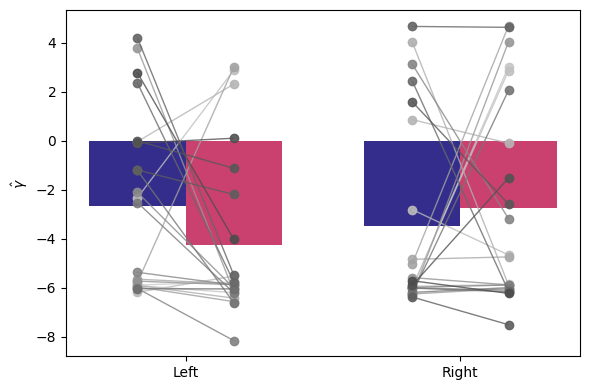

In [ ]:
# Transform into array to compute the mean
# Data is (2x2xnParticipants). The first dimension is the hemisphere, the second
# is the ROI (posterior and anterior).
data = np.array([
     [[betas[p]['left']['posterior'] for p in range(nParticipants)],  # Left, Posterior
      [betas[p]['left']['anterior'] for p in range(nParticipants)]],  # Left, Anterior
     [[betas[p]['right']['posterior'] for p in range(nParticipants)], # Right, Posterior
      [betas[p]['right']['anterior'] for p in range(nParticipants)]]  # Right, Anterior
])

# Compute means: (2, 2) → (hemisphere, location)
means = np.mean(data, axis=2)

# Setup
labels = ['Left', 'Right']
x = np.arange(len(labels))  # [0, 1]
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))

# Plot: Posterior bars on left, Anterior bars on right within each hemisphere group
colors = ['#342d8bff', '#ca406eff']  # Posterior = blue, Anterior = orange

bars_post = ax.bar(x - width/2, means[:, 0], width, label='pHPC', color=colors[0])
bars_ant  = ax.bar(x + width/2, means[:, 1], width, label='aHPC',  color=colors[1])

# Plot participant-level lines and dots
jitter = 0

greys = [str(0.3 + 0.5 * i / (nParticipants - 1)) for i in range(nParticipants)]
greys = list(reversed(greys))
participant_labels = participants

for p in range(nParticipants):
    color = greys[p]
    for i,h in enumerate(gammas[p].keys()):
        x_post = x[i] - width/2
        x_ant  = x[i] + width/2
        y_post = betas[p][h]['posterior']
        y_ant  = betas[p][h]['anterior']

        # Line connecting posterior and anterior
        ax.plot([x_post, x_ant], [y_post, y_ant], '-', color=color, alpha=0.8, linewidth=1)

        # Dots
        ax.plot(x_post, y_post, 'o', color=color, alpha=0.9)
        ax.plot(x_ant,  y_ant,  'o', color=color, alpha=0.9)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel(r'$\hat{\gamma}$')

# Get existing bar legend handles
existing_handles, existing_labels = ax.get_legend_handles_labels()

plt.tight_layout()

plt.show()

In [ ]:
# Statistical test
# We use a very simple paired t-test

df = nParticipants - 1

# Left hemisphere
t_stat, p_value = ttest_rel([gammas[p]['left']['posterior'] for p in range(nParticipants)],
                            [gammas[p]['left']['anterior'] for p in range(nParticipants)])

print(f"Left: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

# Right hemisphere
t_stat, p_value = ttest_rel([gammas[p]['right']['posterior'] for p in range(nParticipants)],
                            [gammas[p]['right']['anterior'] for p in range(nParticipants)])

print(f"Right: t({df}) = {t_stat:.3f}, p = {p_value:.3f}")

Left: t(22) = 0.482, p = 0.634
Right: t(22) = -2.204, p = 0.038


# To do
It would be very nice to have a plot where we display the average estimated $\gamma$ for each of the ROIs, across participants.

Other important controls to run:


*   Check that including a free parameter for $\gamma$ significantly improves the fit (higher $R^2$, lower BIC). If we don't find suh a result, we should run group-level inference
*   Noise ceiling (assess the maximum correlation possible that a model could achieve - we could extend it to MSE)
*   Voxel reliability (to justify choice of probabilistic threshold)
*   Implement a more sound ANOVA to test for main effect of gradient
*   Add the diffusion kernel

Next steps:
*   Model each transition individually (another GLM)
*   Exclude patch trials




# Plot the Gradients

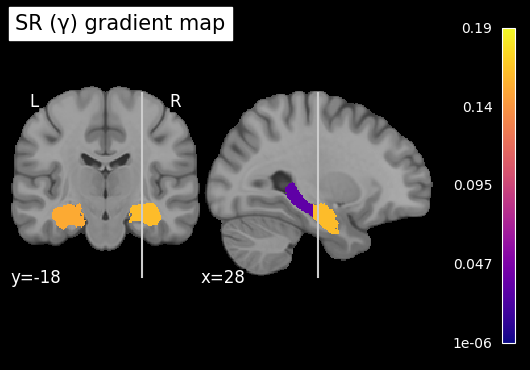

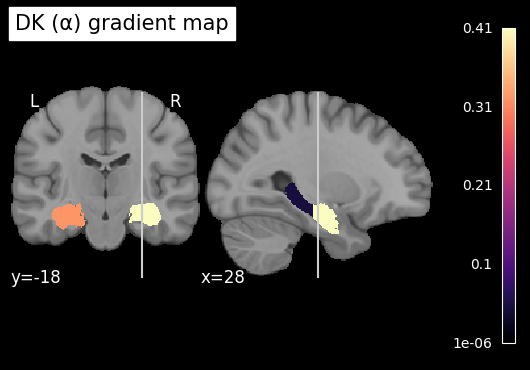

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import plotting, image
from nilearn import datasets # Import datasets module
import matplotlib.pyplot as plt

# Initialize empty volumes
shape = masks_img['left']['posterior'].shape
affine = masks_img['left']['posterior'].affine

# Compute mean γ and α per ROI across participants
mean_gamma = {
    h: {roi: np.mean([gammas[p][h][roi] for p in range(nParticipants)])
        for roi in ['posterior', 'anterior']}
    for h in ['left', 'right']
}

mean_alpha = {
    h: {roi: np.mean([alphas[p][h][roi] for p in range(nParticipants)])
        for roi in ['posterior', 'anterior']}
    for h in ['left', 'right']
}

# Create voxelwise maps weighted by the mean parameter
def make_param_map(params, masks_img):
    vol = np.zeros(shape)
    for h in ['left', 'right']:
        for roi in ['posterior', 'anterior']:
            mask_data = masks_img[h][roi].get_fdata()
            vol[mask_data > 0] = params[h][roi]
    return nib.Nifti1Image(vol, affine)

gamma_map = make_param_map(mean_gamma, masks_img)
alpha_map = make_param_map(mean_alpha, masks_img)

mni_img = datasets.load_mni152_template(resolution=1) # Corrected function call

# SR map (γ)
plotting.plot_stat_map(
    gamma_map,
    bg_img=mni_img,
    title="SR (γ) gradient map",
    display_mode='yx',
    cut_coords=[28, -18],
    cmap='plasma',
    colorbar=True,
    vmax=np.max(gamma_map.get_fdata())
)
plotting.show()

# DK map (α)
plotting.plot_stat_map(
    alpha_map,
    bg_img=mni_img,
    title="DK (α) gradient map",
    display_mode='yx',
    cut_coords=[28, -18],
    cmap='magma',
    colorbar=True,
    vmax=np.max(alpha_map.get_fdata())
)
plotting.show()

In [ ]:
# How tightly do the SR and DK gradients align spatially across participants?

from scipy.stats import pearsonr

for hemi in ["left", "right"]:
    for roi in ["posterior", "anterior"]:
        gamma_vals = [gammas[p][hemi][roi] for p in range(nParticipants)]
        alpha_vals = [alphas[p][hemi][roi] for p in range(nParticipants)]
        r, p = pearsonr(gamma_vals, alpha_vals)
        print(f"{hemi.capitalize()} {roi.capitalize()}: r = {r:.3f}, p = {p:.3f}")

Left Posterior: r = 0.630, p = 0.001
Left Anterior: r = 0.464, p = 0.026
Right Posterior: r = 0.172, p = 0.432
Right Anterior: r = 0.129, p = 0.559


In [ ]:
# Across all participants and the entire HPC gradient
# Valerio said to not concat this, so need to re-work, but do this later!

from scipy.stats import pearsonr

gamma_all = [np.mean([gammas[p][h][roi] for h in ["left","right"] for roi in ["posterior","anterior"]])
             for p in range(nParticipants)]
alpha_all = [np.mean([alphas[p][h][roi] for h in ["left","right"] for roi in ["posterior","anterior"]])
             for p in range(nParticipants)]

r, p = pearsonr(gamma_all, alpha_all)
print(f"Across all ROIs (participant mean): r = {r:.3f}, p = {p:.3f}")


Across all ROIs (participant mean): r = 0.514, p = 0.012
